<a href="https://colab.research.google.com/github/dude123studios/SmarterRing/blob/master/Face_Recognition(200ppl).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import os
import random
import cv2

In [2]:
from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# You can check if everything's okay by running this command.
! kaggle datasets list

# Download and unzip sign-language-mnist dataset into '/usr/local'
! kaggle datasets download -d hereisburak/pins-face-recognition --path '/usr/local' --unzip

Saving kaggle.json to kaggle.json
ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           3190  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    8MB  2021-02-24 07:59:48           1706  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            333  
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:58:25            198  
timoboz/superbowl-history-1967-2020                       Superbowl History 1967 - 2

In [3]:
def load_image(image_path):
  img = cv2.imread(image_path)
  img = tf.convert_to_tensor(img,dtype=tf.float32)
  img = tf.image.resize(img, (64,64))
  img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
  return img

In [4]:
!pip install tqdm
from tqdm import tqdm

In [5]:
path = '/usr/local/105_classes_pins_dataset/'
faces = []
for actor in tqdm(os.listdir(path)):
  faces.append([load_image(path+actor+'/'+actor_name) for actor_name in os.listdir(os.path.join(path,actor))])

100%|██████████| 105/105 [00:38<00:00,  2.73it/s]


In [ ]:
from google.colab import files
files.upload()
#I must manually import my cropped dataset
!mkdir datasets
!unzip bollywood_celeb_faces.zip -d ./datasets

In [7]:
def load_img(image_path):
  with open(image_path, 'rb') as f:
    return np.load(f)

In [8]:
path = './datasets/usr/local/numpy/bollywood_celeb_faces/'
for actor in os.listdir(path):
  faces.append([load_img(path+'/'+actor+'/'+actor_img) for actor_img in os.listdir(os.path.join(path,actor))])

In [9]:
pairs1 = []
pairs2 = []
#produces about 500,000 image pairs, so we only take 50,000 for training time
total = 50000
labels = []
#distance between congruent faces is 0
congruent_label = np.asarray([0])
for class_ in faces:
  for i in range(total // len(faces)):
    j = random.randint(0,len(class_)-2)
    k = random.randint(j+1, len(class_)-1)
    pairs1.append(class_[j])
    pairs2.append(class_[k])
    labels.append(congruent_label)
#all non congruent pairs form 40m pairs which is far too much, 
#so we will randomly choose 50,000
#giving us a more reasonable 100,000 total images, since a lot of epochs will be required
#distant pairs will have a sigmoided distance of 1
non_congruent_label = np.asarray([1])
for i in range(total):
  j = random.randint(0,len(faces)-2)
  k = random.randint(j+1,len(faces)-1)
  l = random.randint(0,len(faces[j])-1)
  m = random.randint(0,len(faces[k])-1)
  pairs1.append(faces[j][l])
  pairs2.append(faces[k][m])
  labels.append(non_congruent_label)

In [10]:
print(len(pairs1))
del faces

99815


In [11]:
def shuffle_in_unison(a, b, c):
    shuffled_a = np.empty((len(a),64,64,3), dtype=np.float32)
    shuffled_b = np.empty((len(a),64,64,3), dtype=np.float32)
    shuffled_c = np.empty((len(c),1), dtype=np.float32)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
        shuffled_c[new_index] = c[old_index]
    return shuffled_a, shuffled_b, shuffled_c
pairs1, pairs2, labels = shuffle_in_unison(pairs1, pairs2, labels)

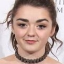

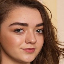

label:  [0.]


In [12]:
from google.colab.patches import cv2_imshow
test_number = 16
cv2_imshow((pairs1[test_number]+1)*127.5)
cv2_imshow((pairs2[test_number]+1)*127.5)
print('label: ', str(labels[test_number]))

In [13]:
class CNN_Block(tf.keras.Model):
  def __init__(self, num_filters, conv_size):
    super(CNN_Block, self).__init__()
    self.conv = Conv2D(num_filters, conv_size, padding='same')
    self.bn = BatchNormalization()
    self.pool = MaxPool2D()

  def call(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = tf.nn.relu(x)
    x = self.pool(x)
    return x

In [14]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    self.block1 = CNN_Block(32, 3)
    self.block2 = CNN_Block(64, 3)
    self.block3 = CNN_Block(128, 3)
    self.block4 = CNN_Block(256, 3)
    self.flatten = Flatten()
    self.dense = Dense(1024, activation='relu')

  def call(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.flatten(x)
    x = self.dense(x)
    return x

In [26]:
class Euclidean_Distance(tf.keras.Model):
  def __init__(self):
    super(Euclidean_Distance, self).__init__()
    self.dense1 = Dense(512)
    self.dense2 = Dense(1, activation='sigmoid')

  def call(self, xA, xB):
    xA = self.dense1(xA)
    xA = tf.nn.leaky_relu(xA)
    xB = self.dense1(xB)
    xB = tf.nn.leaky_relu(xB)
    dist = xA-xB
    x = self.dense2(dist)
    return x

In [22]:
def build_model():
  imgA = Input((64,64,3), dtype=tf.float32, name='inputA')
  imgB = Input((64,64,3), dtype=tf.float32, name='inputB')

  encoder = Encoder()
  featA = encoder(imgA)
  featB = encoder(imgB)

  dist = Euclidean_Distance()
  outputs = dist(featA, featB)

  model = tf.keras.Model(inputs=(imgA, imgB),outputs=outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics='accuracy')
  model.summary()
  return model

In [27]:
with tf.device('gpu:0'):
  inputs = {'inputA':pairs1, 'inputB':pairs2}
  model = build_model()
  model.fit(inputs, labels, epochs=100, batch_size=64)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputA (InputLayer)             [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
inputB (InputLayer)             [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder_4 (Encoder)             (None, 1024)         4585664     inputA[0][0]                     
                                                                 inputB[0][0]                     
__________________________________________________________________________________________________
euclidean__distance_4 (Euclidea (None, 1)            525313      encoder_4[0][0]            

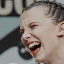

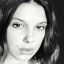

label:  [0.]
Model pred:  [[0.25518537]]


In [28]:
out = model({'inputA':np.expand_dims(pairs1[600],axis=0),'inputB':np.expand_dims(pairs2[600],axis=0)})
from google.colab.patches import cv2_imshow
cv2_imshow((pairs1[600]+1)*127.5)
cv2_imshow((pairs2[600]+1)*127.5)
print('label: ', str(labels[600]))
print('Model pred: ',str(out.numpy()))

In [29]:
model.save_weights('face_recogniton.h5')